# "Hello, it is your political orientation I'm looking for"
## *Can you detect political orientation in Tweets?*

## Introduction

Over the past decade, the rise of Twitter as a means for politicians to connect with and mobilize voters remained irreversible. With, as a recent high- or low point, the permanent ban of former president Donald Trump "due to the risk of further incitement of violence". 

Political analysis with Twitter data shows Twitters' use as "an outlet for propagating political ideologies, exerting influence, generating political polarisation or classifying" (Gruzd & Roy, 2014, p. 28).  With the sharing of opinions and news related to politics or supported causes, cues about political orientation are offered  (Preoţiuc-Pietro et al., 2017, p. 729).

This notebook aims to explore the extent to which the political orientation can be detected in Dutch politicians' Tweets, focusing on the 13 party leaders of the parties currently in the Tweede Kamer, using the Naïve Bayes algorithm.


To start off we will import all liberaries we are going to use in this notebook.

In [1]:
import pandas as pd # to create dataframes
import glob # to retrieve all csv files from a directionary
from datetime import datetime # to handle datetime stamps
import seaborn as sns # to plot figures
import matplotlib.pyplot as plt # to plot figures
import numpy as np # to generate matrices and arrays
import emoji # emoji liberary 
import re # to clean the text of the tweets
from nltk.corpus import stopwords # to remove stopword
from collections import Counter # to count attributes
from sklearn.feature_extraction.text import CountVectorizer # to produce a bag of words
from sklearn.model_selection import train_test_split # produce a training and a test set from out data
from sklearn.naive_bayes import MultinomialNB # imports the model
from sklearn.metrics import confusion_matrix # creates a confusion matrix

## Retrieve the Data

First, we will retrieve the data by scraping all Tweets from all 13 Dutch party leaders currently in the Tweede Kamer. We will retrieve Tweets from (name, Twitter handle, party ): <sup></sup>

- Mark Rutte | @MinPres | VVD
- Geert Wilders | @geertwilderspvv | PVV
- Wopke Hoekstra | @WBHoekstra | CDA
- Sigrid Kaag | @SigridKaag | D66
- Jesse Klaver| @jesseklaver | GL
- Lilian Marijnissen | @MarijnissenL | SP
- Lodewijk Asscher <sup>1</sup>| @LodewijkA | PVDA
- Gert-Jan Segers | @gertjansegers | CU
- Esther Ouwehand | @estherouwehand | PVDD
- Liane den Haan | @LianedenHaan | 50PLUS
- Kees van der Staaij | @keesvdstaaij | SGP 
- Farid Azarkan | @F_azarkan | DENK
- Thierry Baudet | @thierrybaudet | FVD

To do so, we use Tweepy, a Python library for accessing the Twitter API. After creating a Twitter Developer Account and App, we can get to work. Tweepy offers a lot of variables to import. Because we will mainly focus on text analysis we've made the following pre-selection of variables to import:

- User_name: the name of the user
- Timestamp: UTC time when the Tweet was created
- Text: the Tweet
- Is_quote_status: indicates whether this is a quoted Tweet.
- Retweet_count: number of times the Tweet has been retweeted.
- Favorite_count: the amount of times the Tweet has been liked by Twitter users


<sup>1</sup> A few days after collecting the data, Lodewijk Asscher stepped down as party leader. Since he was party leader for over five years, we did decide to use his Tweets as a representation of the PVDA. 

In [2]:
# import tweepy

# consumer_key = "xxx"
# consumer_secret = "xxx"

# access_token = "xxx"
# access_token_secret = "xxx"

# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_token_secret)

# api = tweepy.API(auth)

In [3]:
# username = "name_partyleader"
   
# Creation of query method using parameters
# tweets = tweepy.Cursor(api.user_timeline,id=username, tweet_mode='extended').items()
 
# Pulling information from tweets iterable object
# tweets_list = [[tweet.user.name, tweet.created_at, tweet.full_text, tweet.is_quote_status, tweet.retweet_count, tweet.favorite_count] for tweet in tweets]

# Creation of dataframe from tweets list
# tweets_df = pd.DataFrame(tweets_list)

# tweets_df.columns = ["name", "timestamp","text","quoted tweet","retweet count","favorite count"]

# tweets_df['party']="name_party"

# tweets_df.to_csv("name_partyleader.csv")

In order to create our final dataset we will combine all the Tweet data per user in one dataframe. 

In [4]:
folder = "/Users/marieke/Documents/Studie/final assignment/tweets" # directory where tweets are saved
path = folder+"/**/*.csv" 

# retrieve files
csv_paths = glob.glob(path, recursive=True) 
dfs = [pd.read_csv(csv_path) for csv_path in csv_paths]

# combine files in one dataframe
df = pd.concat(dfs) 

## Pre-processing the Data

Since we will focus on words for our analysis, we will strip the tweets of special characters, emojis and URLs. Although the characters # and @ are used a lot, we removed these but preserved the associated text as part of the corpora we are about to classify. 

In [5]:
# clean the tweets using Regular expressions (to specify the rules for the set of possible strings)

def clean(text):
    # Remove mentions
    txt = re.sub(r"@[A-Za-z0-9_]+", "", text)
    
    # Remove hashtags
    text = re.sub(r"#", "", txt)
    
    # Remove retweets:
    text = re.sub(r"RT : ", "", text)
    
    # Remove urls
    text = re.sub(r"https?:\/\/[A-Za-z0-9\.\/]+", "", text)
    
    # Remove numbers from string
    text = re.sub(r"[0-9]", "", text)
    
    # Remove non latin characters
    text = re.sub(r"[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]", u"", text)
    
    return text

# apply function to column
df["clean text"] = df["text"].apply(clean)

## Feature engeneering

Although we will focus mainly on words for our classification, the Tweets do contain other specific characteristics that could variate strongly between different people and therefore between different political orientations.  

The following information is derived from the original Tweets. These features can be used to contribute to the models' predictive power. 

- Word count: the number of words used in a Tweet

- Retweet: whether the Tweet a retweet of another user

- Emoji count: the amount of emojis used

- Hashtags and hashtag count: Used hashtags and the number of hashtags used. A hashtag groups tweets creating connections between topics.

- Mentions: the number of mentions. A mention is addressed the Tweet to specific users.

In [6]:
# Split the datetime column into date and time

df["date_time"] = df["timestamp"].astype(str)
df["date_time"] = df["date_time"].apply(pd.to_datetime)
df["date"] = df["date_time"].dt.date
df["time"] = df["date_time"].dt.time

In [7]:
# Function to count word per tweet

def word_count(string):
    return(len(re.findall(r'\w+', string))) 

# Apply function to column to create new column
df["word count"] = df["clean text"].apply(word_count)

In [8]:
# Assign true/false if tweet is retweet or not and create new column
df['retweet'] = df['text'].str.contains('RT')

In [9]:
# Count emojis

# Checks if character combination is an emoji
def emoji_count(character):
    return character in emoji.UNICODE_EMOJI

# Function to count emojis
def emoji_counter(text):
    count = 0
    for character in text:
        x = emoji_count(character)
        if x == True:
            count += 1
    return count

# Apply function to column to create new column
df["emoji count"] = df["text"].apply(emoji_counter) 

In [10]:
# Function to count hashtags

def hashtag_count(row, hashtag):
    count = row.count(hashtag)
    return count

# # Apply function to column to create new column
df["hashtag count"]= df["text"].apply(lambda row: hashtag_count(row,"#")) 

In [11]:
# Function to extract hashtags

def find_hashtags(tweet):
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)   

# Apply function to column to create new column
df['hashtags'] = df["text"].apply(find_hashtags) 

In [12]:
# Function to count mentions

def mention_count(row, mention):
    count = row.count(mention)
    return count

# Apply function to column to create new column
df["mention count"]= df["text"].apply(lambda row: mention_count(row,"@")) 

### Assign political orientation

To assign the political orientation and therefore to classify the Tweets from either far left (-2) in the Dutch political landscape to the far right (+2), we have consulted Kieskompas. Kieskompas is an independent research organization that maps the Dutch political landscape. FvD is not on the Kieskompas. We have classified this party as being at the right of the spectrum.

The available data stems from 2017, the year in which the last Dutch elections were. Unfortunately, the Kieskompas for upcoming elections in March 2021 is not yet released.  Tom Etienne, researcher at Kieskompas, did give some remarks regarding the forthcoming Kieskompas: "We see a slight shift to the left, but also that some left-progressive parties are moving more to the centre. The right remains well-populated".

The image below shows the Kieskompas and the classification of the parties based on their position on the map.

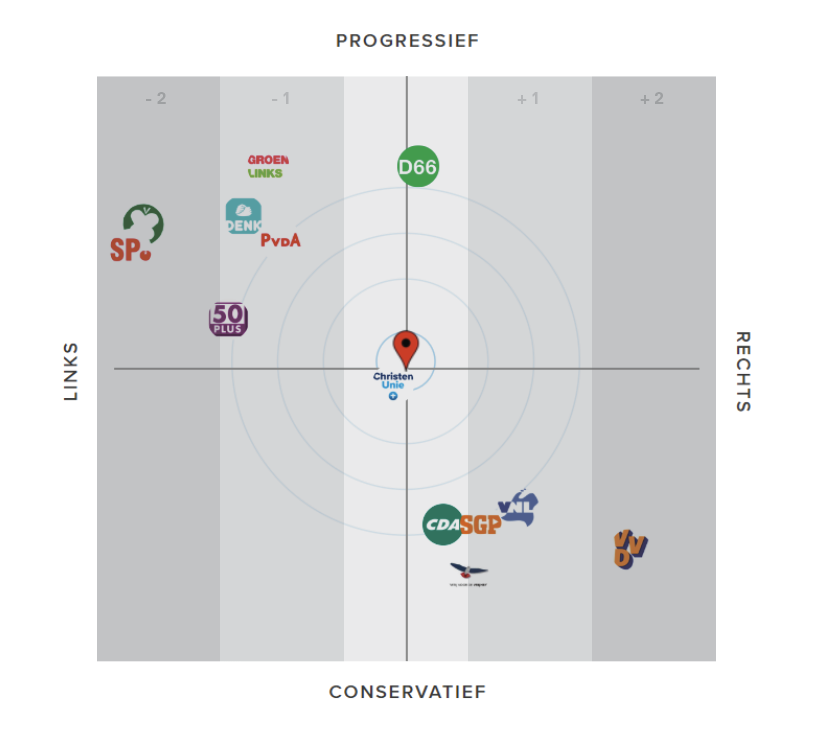

In [13]:
# Assign political orientation

orientation = [] 

# Dictionaries with orientation and parties

left2 = {"SP", "PvdD"}
left1 = {"50PLUS", "Denk", "GL", "PVDA"}
center = {"CU", "D66", "CDA"}
right1 = {"PVV", "SGP"}
right2 = {"VVD", "FvD"}

# Function to assign orientation

for value in df["party"]: 
    if value in left2:
        orientation.append(-2)
    elif value in left1:
        orientation.append(-1)
    elif value in center:
        orientation.append(-0)
    elif value in right1:
        orientation.append(1)
    elif value in right2:
        orientation.append(2)
    else: 
        orientation.append("cannot find party") 
       
df["orientation"] = orientation

In [14]:
df["orientation"] = df["orientation"].astype(int)

In [15]:
# Our final dataframe

df = df[["name", "party", "orientation", "date", "time", "text", "hashtags", "clean text", "quoted tweet", "retweet", "word count", "retweet count", "favorite count", "emoji count", "hashtag count", "mention count"]]
df.head()

,name,party,orientation,date,time,text,hashtags,clean text,quoted tweet,retweet,word count,retweet count,favorite count,emoji count,hashtag count,mention count
0,Kees van der Staaij,SGP,1,2021-01-16,10:20:38,Namens @SGPnieuws feliciteer ik het @Hoornbeec...,[#ROC],Namens feliciteer ik het van harte! Wat mooi...,False,False,26,17,82,0,1,2
1,Kees van der Staaij,SGP,1,2021-01-16,09:01:46,RT @SGPnieuws: 'Ik hoop dat er zo lang mogelij...,[#StudioSGP],'Ik hoop dat er zo lang mogelijk echt ruimte b...,False,True,20,3,0,0,1,2
2,Kees van der Staaij,SGP,1,2021-01-15,21:46:12,Bekijk de uitzending van #StudioSGP terug op Y...,[#StudioSGP],Bekijk de uitzending van StudioSGP terug op Yo...,True,False,8,1,13,0,1,0
3,Kees van der Staaij,SGP,1,2021-01-15,18:35:03,RT @SGPnieuws: We zijn LIVE met #StudioSGP! Te...,[#StudioSGP],"We zijn LIVE met StudioSGP! Te gast zijn , , M...",False,True,17,4,0,0,1,3
4,Kees van der Staaij,SGP,1,2021-01-15,18:01:07,RT @SGPnieuws: We gaan over 30 minuten live me...,"[#StudioSGP, #kabinet, #RutteIII]",We gaan over minuten live met een EXTRA LANGE...,False,True,16,2,0,0,3,3


## Exploratory data analysis 

The dataset contains a total of 37,221 tweets by thirteen party leaders divided over five classes.  The graph below shows an imbalance in the class distribution. Much research has been done on dealing with class imbalance; for example, on undersampling or oversampling (Yap et al, 2014).  Nevertheless, in this dataset, we decide to keep the classes as they occur. It is, however, essential to keep the imbalance in mind when evaluating the model. 

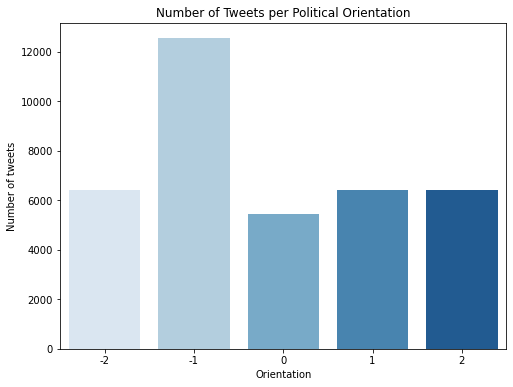

In [16]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="orientation", data=df, palette="Blues")
plt.title("Number of Tweets per Political Orientation")
plt.ylabel("Number of tweets")
plt.xlabel("Orientation")
plt.show()

In [17]:
table1 = df["party"].groupby(df["orientation"]).value_counts(normalize=True)
table1

orientation  party 
-2           PvdD      0.501014
             SP        0.498986
-1           PVDA      0.258828
             50PLUS    0.256835
             Denk      0.251255
             GL        0.233081
 0           CU        0.590800
             D66       0.249126
             CDA       0.160074
 1           SGP       0.501559
             PVV       0.498441
 2           VVD       0.501714
             FvD       0.498286
Name: party, dtype: float64

#### Tweet is a quote

The absolute amount of non quoted tweets is in the -1 class. After normalizing the variable, it becomes evident that the distribution among the classes is relatively even (as shown in the figure and table below). This makes this feature not very usable in predicting a class because it does not distinguish the classes from each other.

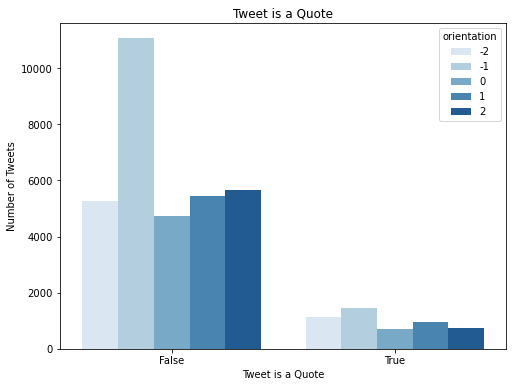

In [18]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="quoted tweet", hue="orientation", data=df, palette="Blues")
plt.title("Tweet is a Quote")
plt.ylabel("Number of Tweets")
plt.xlabel("Tweet is a Quote")
plt.show()

In [19]:
pd.crosstab(df["quoted tweet"], df["orientation"], normalize='columns') * 100

orientation,-2,-1,0,1,2
quoted tweet,,,,,
False,82.171268,88.266242,86.954922,85.095104,88.388404
True,17.828732,11.733758,13.045078,14.904896,11.611596


#### Tweet is a Retweet

This variable is a little less evently distributed. If we look at the table below, we can see that especially the center (orientation: 0) is not very keen on Retweeting other users' Tweets. We could decide on filtering all Retweets out, because it is not original content from the user itself. On the other hand, studies show that people do tend for commuication purpose (initiating a conversation), social relationship maintenance and self- expression (LEE et al., 2015, p. 190) therefore making it a integral part of their personal vocabulary. 

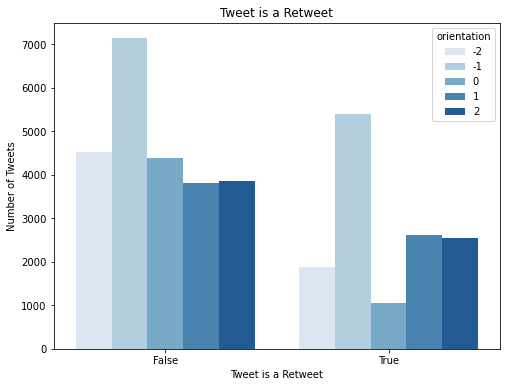

In [20]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="retweet", hue="orientation", data=df, palette="Blues")
plt.title("Tweet is a Retweet")
plt.ylabel("Number of Tweets")
plt.xlabel("Tweet is a Retweet")
plt.show()

In [21]:
pd.crosstab(df["retweet"], df["orientation"], normalize='columns') * 100

orientation,-2,-1,0,1,2
retweet,,,,,
False,70.51942,56.899163,80.809568,59.40131,60.271197
True,29.48058,43.100837,19.190432,40.59869,39.728803


#### Amount of words per Tweet



The maximum amount of characters set to 280 can contain quite some words. Yet the median amount of words used among the classes is somewhere between 15 and 20. This is in line with research that shows that shorter Tweets generate more engagement. 
Yet, sometimes more words are needed:  all classes show data points in the third quartile range. The distribution differs most between the classes -2 / 0 and -1 / 1 / 2.  

Most words are counting within class -1, but this class also withholds the most Tweets. 

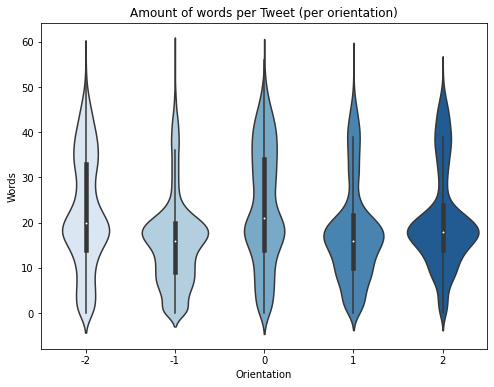

In [22]:
plt.figure(figsize=(8, 6))
ax = sns.violinplot(x="orientation", y="word count", data=df, palette="Blues")
plt.title("Amount of words per Tweet (per orientation)")
plt.ylabel("Words")
plt.xlabel("Orientation")
plt.show()

In [23]:
table2 = df.groupby("orientation")["word count"].sum().reset_index()
table2["percentage"] = (table2["word count"] / table2["word count"].sum()) * 100
table2 = table2.sort_values(by="percentage", ascending = False)
print(table2)

   orientation  word count  percentage
1           -1      196938   27.588071
0           -2      142661   19.984675
4            2      132411   18.548803
2            0      127592   17.873733
3            1      114250   16.004718


In [24]:
table3 = df[["name", "party", "orientation", "date", "text", "word count"]]
table3 = table3[(table3["word count"] > 50)]
table3.nlargest(15,["word count"]) # plot outliers to investigate

,name,party,orientation,date,text,word count
1863,Lodewijk Asscher,PVDA,-1,2019-06-07,“In the end England were schooled by a Dutch t...,58
294,Geert Wilders,PVV,1,2020-11-12,Ik ben al 16 jaar mijn vrijheid kwijt en word ...,56
659,Gert-Jan Segers,CU,0,2020-08-29,"Het enige wat me dan helpt, is de overtuiging ...",56
1265,Esther Ouwehand,PvdD,-2,2019-11-02,De kunst van het menszijn? Iig dit: open en mo...,56
441,Gert-Jan Segers,CU,0,2020-10-26,Take these hands\nTeach them what to carry\nTa...,55
999,Gert-Jan Segers,CU,0,2020-06-03,@janwillemwits Heel belangrijk dat het idd gaa...,55
3011,Gert-Jan Segers,CU,0,2018-12-05,"@HansHaarsma Dat is niet flauw, maar precies h...",55
524,Jesse Klaver,GL,-1,2019-11-13,Als je een halfjaar de tijd hebt voor een cris...,55
2808,Esther Ouwehand,PvdD,-2,2018-12-10,@noknokitsme @Lizzivnimwegen Vrijwel alle vega...,55
862,Gert-Jan Segers,CU,0,2020-06-25,@RubenRos8 @PD_Dekker @ceemonrooij Weet niet h...,54


#### Amount of Retweets 

The amount of Times a Tweet is Retweets shows one enormous outlier. When investigating the Tweet, the Tweets concerns the most Retweeted Tweet of 2020, the message about Chadwick Boseman's passing (NOS, 2020). After removing this Tweet from the dataset, the graph shows a clearer view of the Retweets' distribution per orientation. 
Remarkably, the centre (0) doesn't get Retweeted much.

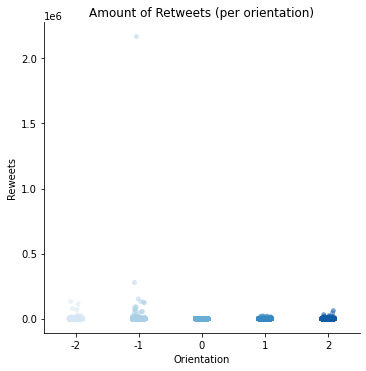

In [25]:
ax = sns.catplot(x="orientation", y="retweet count", data=df, palette="Blues", alpha = 0.5)
plt.title("Amount of Retweets (per orientation)")
plt.ylabel("Reweets")
plt.xlabel("Orientation")
plt.show()

In [26]:
table4 = df[["name", "party", "orientation", "date", "text", "retweet count"]]
table4 = table4[(table4["retweet count"] > 10000 )]
table4.sort_values(by="retweet count", ascending = False)
table4.nlargest(10, ['retweet count']) # plot outliers to investigate

,name,party,orientation,date,text,retweet count
728,Farid Azarkan,Denk,-1,2020-08-29,RT @chadwickboseman: https://t.co/aZ2JzDf5ai,2168029
2983,Farid Azarkan,Denk,-1,2018-02-23,RT @helenhousandi: I've watched this GIF at le...,278122
79,Farid Azarkan,Denk,-1,2021-01-06,RT @bubbaprog: Cops are taking selfies with th...,151638
26,Esther Ouwehand,PvdD,-2,2021-01-06,RT @LucasBrownEyes: As we watch Trumpers storm...,131622
1070,Farid Azarkan,Denk,-1,2020-06-06,RT @BradfordPearson: The crowd in Philly is......,130859
1110,Farid Azarkan,Denk,-1,2020-05-29,RT @BerniceKing: If you’re unbothered or mildl...,126854
2111,Lodewijk Asscher,PVDA,-1,2019-04-15,RT @Inaki_Gil: Ave Maria https://t.co/lb6Y5XV05a,121691
33,Lilian Marijnissen,SP,-2,2021-01-06,RT @BernieSanders: The man directly responsibl...,114281
1169,Farid Azarkan,Denk,-1,2020-05-16,RT @sarahcpr: How to more cases than anybody i...,91850
2509,Lodewijk Asscher,PVDA,-1,2019-01-25,RT @briantylercohen: Wow. I’ve never seen anyt...,90514


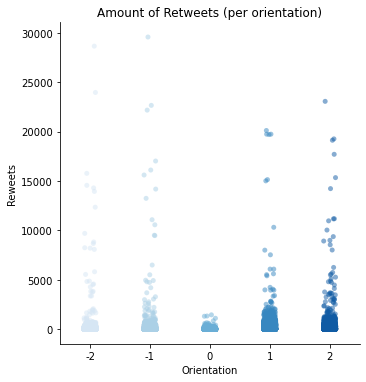

In [27]:
table5 = df[(df["retweet count"] < 30000 )]
ax = sns.catplot(x="orientation", y="retweet count", data=table5, palette="Blues", alpha = 0.5)
plt.title("Amount of Retweets (per orientation)")
plt.ylabel("Reweets")
plt.xlabel("Orientation")
plt.show() # plot without outliers 

#### Amount of favorited Tweets 

The distribution of the amount of favorited tweets also has some massive outliers. When investigating more closely in the violin plots, it turn out that the median amount of favorited Tweets is closer to 10 then to ten thousands. It seems the amount of favorited Tweets is especially high in class 1. When zooming in especially, the PVV has a lot of favorited Tweets. It could be interesting to research if this might have to do with the PVV's populist rhetoric. 

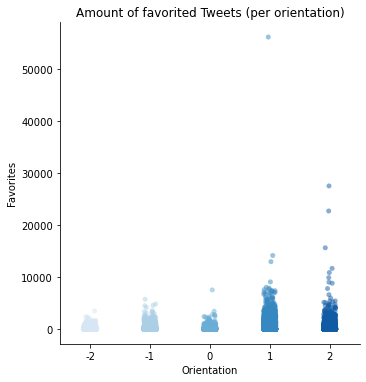

In [28]:
ax = sns.catplot(x="orientation", y="favorite count", data=df, palette="Blues", alpha = 0.5)
plt.title("Amount of favorited Tweets (per orientation)")
plt.ylabel("Favorites")
plt.xlabel("Orientation")
plt.show()

In [29]:
table6 = df[["name", "party", "orientation", "date", "text", "favorite count"]]
table6 = table6[(table6["favorite count"] > 12000 )]
table6.sort_values(by="favorite count", ascending = False)
table6.nlargest(10, ["favorite count"])  # plot outliers to investigate

,name,party,orientation,date,text,favorite count
2717,Geert Wilders,PVV,1,2019-08-05,India is a full democracy.\nPakistan is a 100%...,56181
19,Mark Rutte,VVD,2,2021-01-06,Horrible images from Washington D.C. Dear @rea...,27547
1833,Mark Rutte,VVD,2,2017-06-27,नीदरलैंड्स में पधारने के लिए धन्यवाद @narendra...,22726
152,Mark Rutte,VVD,2,2020-10-26,President Erdogan’s words addressing President...,15657
434,Geert Wilders,PVV,1,2020-10-24,Terrorist. https://t.co/jxdnDhk9ti,14175
2695,Geert Wilders,PVV,1,2019-08-11,Today the islamic Eid al Adha - the “Festival ...,12985


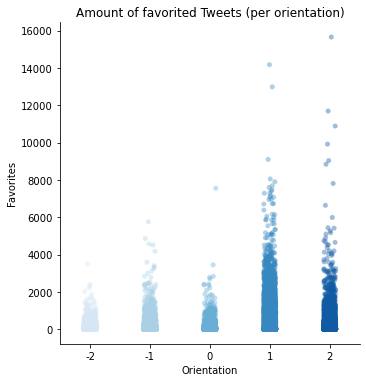

In [30]:
table7 = df[(df["favorite count"] < 20000 )]
ax = sns.catplot(x="orientation", y="favorite count", data=table7, palette="Blues", alpha = 0.4)
plt.title("Amount of favorited Tweets (per orientation)")
plt.ylabel("Favorites")
plt.xlabel("Orientation")
plt.show() # plot without outliers 

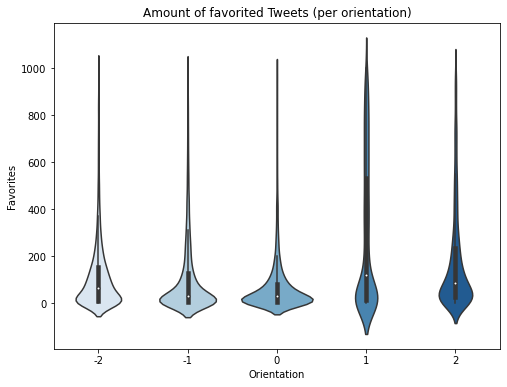

In [31]:
table8 = df[(df["favorite count"].between(1, 1000)) ]
plt.figure(figsize=(8, 6))
ax = sns.violinplot(x="orientation", y="favorite count", data=table8, palette="Blues")
plt.title("Amount of favorited Tweets (per orientation)")
plt.ylabel("Favorites")
plt.xlabel("Orientation")
plt.show() # plot without outliers 

In [32]:
df.groupby(["party"])["favorite count"].sum().sort_values(ascending=False).reset_index()

,party,favorite count
0,PVV,3257022
1,VVD,717249
2,FvD,699899
3,GL,407793
4,SP,319404
5,PVDA,294086
6,PvdD,207461
7,CU,173934
8,D66,170822
9,SGP,115689


#### Amount of Emojis in Tweet

Of all Tweets in this dataset 88% don't contain emojis. The class -2 uses by far the most emojis.  The distribution of emojis of class 0 en 2 is rather simular.  When used in the model, it will mostly distinct the -2 and -1 classes from the other classes. 

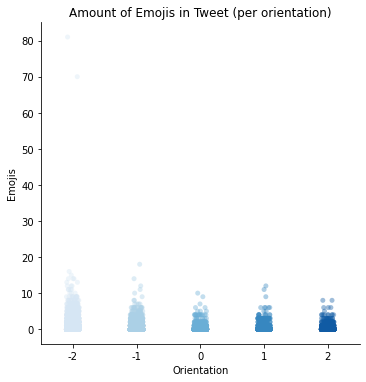

In [33]:
ax = sns.catplot(x="orientation", y="emoji count", data=df, palette="Blues", alpha = 0.4)
plt.title("Amount of Emojis in Tweet (per orientation)")
plt.ylabel("Emojis")
plt.xlabel("Orientation")
plt.show()

In [34]:
df["emoji count"].value_counts(normalize=True).nlargest(5).to_frame()

,emoji count
0,0.887510
1,0.070659
2,0.020660
3,0.009779
4,0.004702


In [35]:
table10 = df[["name", "party", "orientation", "date", "text", "emoji count"]]
table10 = table10[(table10["emoji count"] > 15)]
table10.sort_values(by="emoji count", ascending = False)
table10.nlargest(5, ["emoji count"]) # plot outliers to investigate

,name,party,orientation,date,text,emoji count
1324,Esther Ouwehand,PvdD,-2,2019-10-20,Conclusie @VPROTegenlicht: minstens 3x zoveel ...,81
3014,Esther Ouwehand,PvdD,-2,2018-11-09,@kutheks @Wouter_Pieterse 🖤🖤🖤🖤🖤🖤🖤🖤🖤🖤🖤🖤🖤🖤🖤🖤🖤🖤🖤🖤...,70
1608,Farid Azarkan,Denk,-1,2019-12-02,RT @AlexanderNL: 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥 https://t....,18
2268,Esther Ouwehand,PvdD,-2,2019-03-10,@ytstopmovie 🙌🏼🙌🏼🙌🏼🌱💚🐮🌍🙌🏼🙌🏼🙌🏼,16


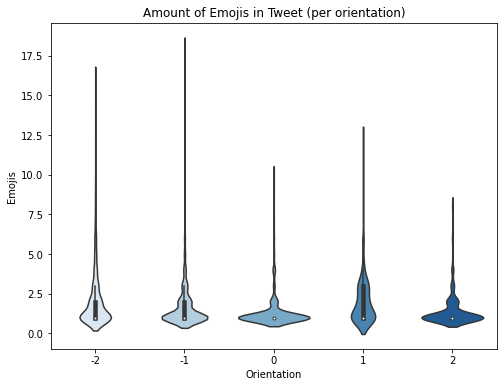

In [36]:
table9 = df[(df["emoji count"].between(1, 20)) ]
plt.figure(figsize=(8, 6))
ax = sns.violinplot(x="orientation", y="emoji count", data=table9, palette="Blues")
plt.title("Amount of Emojis in Tweet (per orientation)")
plt.ylabel("Emojis")
plt.xlabel("Orientation")
plt.show() # plot without outliers 

In [37]:
df.groupby(["orientation"])["emoji count"].sum().sort_values(ascending=False).reset_index()

,orientation,emoji count
0,-2,4139
1,-1,2010
2,0,642
3,2,520
4,1,460


#### Amount of Hashtags in Tweet

Most Tweets don't contain hashtags (around 70%). Again when looking closer, Geert Wilders from the PVV uses a lot of hashtags. Also, in this case, it could be interesting to research if this might have to do with the PVV's populist rhetoric.

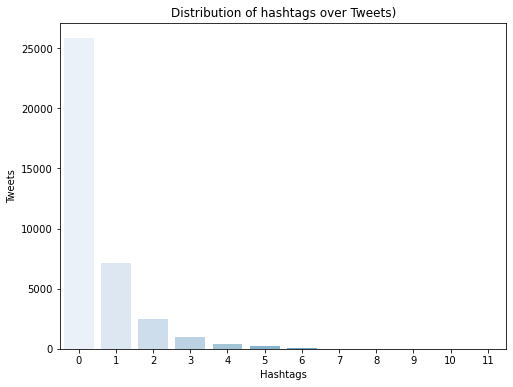

In [38]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="hashtag count", data=df, palette="Blues")
plt.title("Distribution of hashtags over Tweets)")
plt.ylabel("Tweets")
plt.xlabel("Hashtags")
plt.show()

In [39]:
df["hashtag count"].value_counts(normalize=True).nlargest(5).to_frame()

,hashtag count
0,0.694017
1,0.191263
2,0.067569
3,0.027458
4,0.011687


In [40]:
tableA = df[["name", "party", "orientation", "date", "hashtags", "hashtag count"]]
tableA = tableA[(tableA["hashtag count"] > 0 )]
tableA.sort_values(by="hashtag count", ascending = False)
tableA.nlargest(10, ["hashtag count"]) 

,name,party,orientation,date,hashtags,hashtag count
462,Geert Wilders,PVV,1,2020-10-19,"[#SamuelPaty, #muhammadcartoon, #MohammedCarto...",11
2686,Geert Wilders,PVV,1,2019-08-13,"[#burqa, #nikab, #hijab, #AlQaeda, #Zawahiri, ...",11
2774,Geert Wilders,PVV,1,2019-07-20,"[#terrorstates, #freedom, #islam, #RuleOfLaw, ...",11
753,Geert Wilders,PVV,1,2020-08-19,"[#Covid_19, #Corona, #coronawet, #COVID19NL, #...",10
1578,Geert Wilders,PVV,1,2020-03-18,"[#lockdown, #Coronavirusnl, #coronavirusNederl...",9
2383,Geert Wilders,PVV,1,2019-10-10,"[#Turkije, #NAVO, #Turkey, #NATO, #ExpelTurkey...",9
103,Geert Wilders,PVV,1,2020-12-24,"[#PVV, #Kerstvideo, #kerst, #kerst2020, #PVV, ...",8
269,Geert Wilders,PVV,1,2020-11-16,"[#hongarije, #hungary, #Orban, #Nexit, #EU, #V...",8
471,Geert Wilders,PVV,1,2020-10-16,"[#Paris, #ParisAttacks, #Cartoons, #Muhammad, ...",8
472,Geert Wilders,PVV,1,2020-10-16,"[#Paris, #Mohammed, #muhammad, #cartoon, #neve...",8


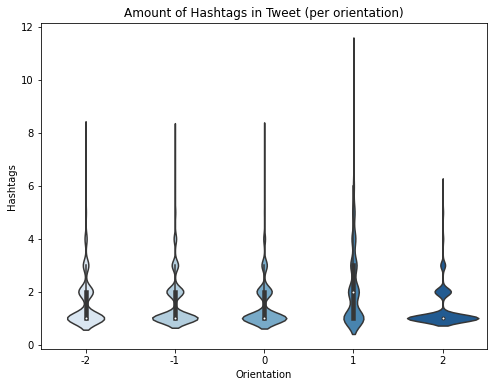

In [41]:
plt.figure(figsize=(8, 6))
tablex = tableA[(tableA["hashtag count"] > 0 )]
ax = sns.violinplot(x="orientation", y="hashtag count", data=tablex, palette="Blues")
plt.title("Amount of Hashtags in Tweet (per orientation)")
plt.ylabel("Hashtags")
plt.xlabel("Orientation")
plt.show()

## Revisiting our final Dataframe

After our exploratory data analysis, we decide to make a few slight changes based on our observations. In this case, the changes will have to do with removing the outliers of our numerical values so that we might use these as an additional feature for our model later on.

In [42]:
# tweaks in data frame

## Building the Model

For our analysis, we need to transform our text to be able to use it. A common approach for extracting features from text is to use the bag of words model. This model will consider the occurrence of words. The order in which they occur is disregarded (hence the idea of a bag). We will use CountVectorizer for this process. After that, we will create a document-feature matrix, with text (our Tweets) in rows, and features (words) in columns.

#### Tweaking Countvectorizers' parameters

1. Stop words: CountVectorizer counts the occurrence of each word in its assigned vocabulary. Stop words are a list of words we don't want to use as features because they are omnipresent words like 'the', 'and', etc. We will set the stop words parameter to 'Dutch' for this model. We can also add a custom list with stopwords to remove additional words.


2. Max_df / Min_df: is used to remove terms that appear too frequently or too infrequently.  For example, max_df = 0.20 means "ignore terms that appear in more than 20% of the text" or  min_df = 10 means "ignore terms that appear in less than 10 documents". 


3. Max_features:  CountVectorizer will choose the words that occur most often the assigned vocabulary (for example, the 200 most used words) and discards all other words.

In [43]:
# Set the Dutch stopword list
final_stopwords_list = stopwords.words("dutch")

# Taking the text from the df. We need to convert it to Unicode
text = df["clean text"].values.astype('U') 

# Creates the CV object
vect = CountVectorizer(stop_words=final_stopwords_list) 

# We fit the model with the cleaned tweets
vect = vect.fit(text) # 

#G et the words from the vocabulary
feature_names = vect.get_feature_names() 

print(f"There are {len(feature_names)} words in the vocabulary. A selection: {feature_names[30:60]}")

There are 43054 words in the vocabulary. A selection: ['aanbieders', 'aanbieding', 'aanbiedingen', 'aanbiedingsspe', 'aanbiedingsspeech', 'aanbiedt', 'aanbinden', 'aanblik', 'aanbod', 'aanboort', 'aanbouw', 'aanbreken', 'aanbrengen', 'aandacht', 'aandachtig', 'aandachtishetni', 'aandachtvoorelkaar', 'aandee', 'aandeel', 'aandeelhoud', 'aandeelhouder', 'aandeelhouders', 'aandeelhoudersbelang', 'aandeelhouderskapatalisme', 'aandeelhouderskapitalisme', 'aandeelhoudersmacht', 'aandeelhoudersvergadering', 'aandelen', 'aandelenaankoop', 'aandeleninkoop']


In [44]:
# Make a matrix

docu_feat = vect.transform(text) 

## Create the model

The model we are going to use to classify the Tweets orientation is Naive Bayes. The algorithm allows us to predict a class, given a set of features using probability. The Naïve Bayes method oftentimes performs surprisingly strong in text classification tasks (Verhoeven, 2013, p. 9).

In [45]:
# Create the model
nb = MultinomialNB() 

# The document-feature matrix is the X matrix
X = docu_feat 

# Creating the y vector
y = df["orientation"] 

# Split the data into a train and test set and store it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

# Fit the model 
nb = nb.fit(X_train, y_train) 

## Evaluating the Model

To check how our model performed, we will evaluate the model using measures of accuracy, a confusion matrix and a classification report containing precision and recall.

In [46]:
# Evaluate the model

y_test_p = nb.predict(X_test)
nb.score(X_test, y_test)

0.6576520103877497

#### Accuracy

The accuracy score reflects the overall accuracy of our model. In our case, the percentage of Tweets correctly classified by our model is 66%. This score is not great, but significantly higher than if we would consequently guess the class -1 (our largest class, please see table below).  Also, with imbalanced classes (as we concluded earlier in our exploratory data analysis), it is easier to get a higher accuracy simply because the number of cases in a certain class is more extensive. 

In [47]:
df["orientation"].value_counts(normalize=True) # check percentage of data per class

-1    0.337041
 2    0.172376
 1    0.172322
-2    0.172241
 0    0.146020
Name: orientation, dtype: float64

In [48]:
nb.classes_ # check the order of the arrays

array([-2, -1,  0,  1,  2])

In [49]:
cm = confusion_matrix(y_test, y_test_p)
cm = pd.DataFrame(cm, index=['-2', '-1', '0', '1', '2'], columns=['-2 pred', '-1 pred', '0 pred', '1 pred', '2 pred'])
cm

,-2 pred,-1 pred,0 pred,1 pred,2 pred
-2,1148,586,74,36,41
-1,301,3064,146,134,150
0,101,589,769,60,114
1,95,453,107,1158,84
2,105,421,143,83,1205


#### Confusion matrix

- The model predicted 1169 labels correctly as -2 (positive) and 8647 classes correctly as not -2 (negative).

- The model predicted 624 labels as negatives (not -2), but they were actually positive (they were -2) (false positives) and 727 labels were predicted as positives (-2) even though they are negatives (not -2) (false negatives).



In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_p))

              precision    recall  f1-score   support

          -2       0.66      0.61      0.63      1885
          -1       0.60      0.81      0.69      3795
           0       0.62      0.47      0.54      1633
           1       0.79      0.61      0.69      1897
           2       0.76      0.62      0.68      1957

    accuracy                           0.66     11167
   macro avg       0.68      0.62      0.64     11167
weighted avg       0.67      0.66      0.65     11167



#### Precision and recall

- Precision: the higest prediction for class 1 and the lowest for class -1. This number tells us what proportion of the labels were predicted correctly out of the total predictions for that class. As an example: Precision tells us what proportion of messages a model classified as spam, actually were spam. 
- Recall: the higest prediction for class -1 and the lowest for class 0. This is the number of correct predictions out of true labels for that class. For example, recall(sensitivity) tells us what proportion of messages that actually were spam were classified by a model as spam

## Improvement

In [51]:
# Set the Dutch stopword list
final_stopwords_list = stopwords.words("dutch")

# Taking the text from the df. We need to convert it to Unicode
text = df["clean text"].values.astype('U') 

# Creates the CV object
vect = CountVectorizer(stop_words=final_stopwords_list, max_df=0.07) #max_features=

# We fit the model with the cleaned tweets
vect = vect.fit(text) # 

# Get the words from the vocabulary
feature_names = vect.get_feature_names() 

print(f"There are {len(feature_names)} words in the vocabulary. A selection: {feature_names[30:60]}")

There are 43053 words in the vocabulary. A selection: ['aanbieders', 'aanbieding', 'aanbiedingen', 'aanbiedingsspe', 'aanbiedingsspeech', 'aanbiedt', 'aanbinden', 'aanblik', 'aanbod', 'aanboort', 'aanbouw', 'aanbreken', 'aanbrengen', 'aandacht', 'aandachtig', 'aandachtishetni', 'aandachtvoorelkaar', 'aandee', 'aandeel', 'aandeelhoud', 'aandeelhouder', 'aandeelhouders', 'aandeelhoudersbelang', 'aandeelhouderskapatalisme', 'aandeelhouderskapitalisme', 'aandeelhoudersmacht', 'aandeelhoudersvergadering', 'aandelen', 'aandelenaankoop', 'aandeleninkoop']


In [52]:
# Make a matrix

docu_feat = vect.transform(text) 

In [53]:
# Create the model
nb = MultinomialNB() 

# The document-feature matrix is the X matrix
X_plus = np.c_[X.toarray(), df["emoji count"]] #X.toarray() converts the sparse array to a normal array. This takes up somewhat more memory. However, not as much as making it into a dataframe. Then np.c_ concatenates the columns.

# Creating the y vector
y = df["orientation"] 

# Split the data into a train and test set and store it
X_train_plus, X_test_plus, y_train_plus, y_test_plus = train_test_split(X_plus, y, test_size=0.3) #split the data and store it

# Fit the model 
nb = nb.fit(X_train, y_train) 

In [54]:
#Naive Bayes
nb = MultinomialNB() #create the model
nb = nb.fit(X_train_plus, y_train_plus) #fit the model X=features, y=character
nb_score = nb.score(X_test_plus, y_test_plus)
nb_score

0.6543386764574192

It seems the model did not get improved by our efforts. Room voor more tweaking in a follow-up investigation! 

#### Test some prediction

In [58]:
print(df.iloc[11,7])
print(nb.predict_proba(X[0]))

"Dat helpt de samenleving, dat helpt de politiek en het inspireert om steeds weer op te komen, aandacht te hebben voor 


ValueError: dimension mismatch

In [59]:
print(df.iloc[1300,7])
print(nb.predict_proba(X[0]))

 Dank!!


ValueError: dimension mismatch

In [60]:
print(df.iloc[3000,7])
print(nb.predict_proba(X[0]))

Belangrijk dat pervers systeem steunverlening aan palestijnse gevangenen stopt. Hard nodig dat internationale druk verder wordt opgevoerd.


ValueError: dimension mismatch

#### Words with greatest predicable values

In [ ]:
df = pd.DataFrame(nb.feature_log_prob_,columns=feature_names)
df1_transposed = df.T

In [ ]:
or_min_two = df1_transposed[0].sort_values(ascending = False)[0:10] 
or_min_one = df1_transposed[1].sort_values(ascending = False)[0:10] 
or_zero = df1_transposed[2].sort_values(ascending = False)[0:10] 
or_one = df1_transposed[3].sort_values(ascending = False)[0:10] 
or_two =df1_transposed[4].sort_values(ascending = False)[0:10]

In [ ]:
df1_transposed = df.T

####  class -2

In [ ]:
or_min_two

#### class -1

or_min_one

#### class 0

In [ ]:
or_zero

#### class 1

In [ ]:
or_one

#### class 2

In [ ]:
or_two

## Conclusion

A lot of research is being done on the terrain of political siences and this use of Twitter. An example is a recent paper on extreme right-wing populism: *Trend towards extreme right-wing populism on Twitter. An analysis of the influence on leaders, media and users* (Pérez-Curiel, 2020).

This type of model could, for example, be used to predict the political alignment of users (as a representation of society).

In regards to optimizing the model there is still a lot to gain. We could add more words to the stop words. Or for example, in stemming and lemmatization, both ways of analyzing words in a corpus based on their roots. When this research was conducted these libraries where not yet available for the Dutch language (at least not un a form this researcher is able to use). Other ideas could be the extracting of information on the URLs tweeted. Since Twitter shortens, URLs information about the context is lost there (Fernandes de Mello Araújo & Ebbelaar, 2018, pp. 1–3). Last but not least, emojis could also be used, as characters, not as counted amounts. The same goes for hashtags. 



## Appendix - Emoji Shallow Deep Dive

Next to the emoji count, it could also be fascinating to use emojis in our model. There are ways to this, for example, to use the textual representation of the emoji. For now, we just satisfy our curiosity with a simple overview of the most used emojis in Dutch politics.

The following code is originally created by Krzemińska, 2020.

In [ ]:
def emoji_count(character):
    return character in emoji.UNICODE_EMOJI

# Function to count emojis
def emoji_counter(text):
    count = 0
    for character in text:
        x = emoji_count(character)
        if x == True:
            count += 1
    return count

In [ ]:
# create a corpus

words_filtered = []

for row in df["text"]:
    for w in row:
        if w not in final_stopwords_list:
            words_filtered.append(w)
            
count = Counter(words_filtered)

# turn counter into a dictionary
dictionary = dict(count)

# list all emojis found in the counter
emoji_list = []

for item in dictionary:
    if emoji_count(item):
        emoji_list.append(item)
        
# dictionary for the frequency of emojis
dictionary_emoji = {}

for emoji in dictionary:
    frequency = count[emoji]
    if emoji in emoji_list:
        dictionary_emoji[emoji] = frequency

In [ ]:
# sort the emoji by frequency

sorted_emojis = {key: value for key, value in sorted(dictionary_emoji.items(), key=lambda item: item[1], reverse=True)}
print(f"There are {len(emoji_list)} different emojis used in the Tweets.")

In [ ]:
# print the top 50 most used emojis

top_50 = sorted_emojis.items()
top = list(top_50)[:50]
print(top)

print(f"These are the 50 most used emojis:")

While most of the used emojis are pretty self explanatory (even without the context, we understand how they are used) some emojis deserve a little explanation. For example:

🏼🏻🏽 are part of an Emoji ZWJ Sequence, a combination of multiple emojis which display as a single emoji on supported platforms (Burge, 2016).

🇱 🇳 🇪 🇺are a Regional Indicator Symbol Letter. Combinations of those letters dislplay as a flag. For example: the Dutch flag consists out of 🇳 Regional Indicator Symbol Letter N and 🇱 Regional Indicator Symbol Letter L. To display the EU flag 🇪and 🇺are being used.

## References

Gruzd, A., & Roy, J. (2014). *Investigating Political Polarization on Twitter: A Canadian Perspective. Policy & Internet, 6(1), 28–29*. https://doi.org/10.1002/1944-2866.poi354

Preoţiuc-Pietro, D., Liu, Y., Hopkins, D., & Ungar, L. (2017). *Beyond Binary Labels: Political Ideology Prediction of Twitter Users. Proceedings of the 55th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers), 729.* https://doi.org/10.18653/v1/p17-1068

Yap, B. W., Rani, K. A., Rahman, H. A. A., Fong, S., Khairudin, Z., & Abdullah, N. N. (2013). *An Application of Oversampling, Undersampling, Bagging and Boosting in Handling Imbalanced Datasets. Lecture Notes in Electrical Engineering, 13–22*. https://doi.org/10.1007/978-981-4585-18-7_2


LEE, M., KIM, H., & KIM, O. (2015). *WHY DO PEOPLE RETWEET A TWEET?: ALTRUISTIC, EGOISTIC, AND RECIPROCITY MOTIVATIONS FOR RETWEETING. PSYCHOLOGIA, 58(4), 189–201.* https://doi.org/10.2117/psysoc.2015.189

NOS. (2020, December 8). *Overlijdensbericht Chadwick Boseman meest gedeelde tweet in 2020.* https://nos.nl/artikel/2359736-overlijdensbericht-chadwick-boseman-meest-gedeelde-tweet-in-2020.html

Pérez-Curiel, C. (2020). *Trend towards extreme right-wing populism on Twitter. An analysis of the influence on leaders, media and users. Communication & Society, 33(2), 175–192.* https://doi.org/10.15581/003.33.2.175-192

Krzemińska, M. (2020, September 28). *Does Emoji Use Correlate With Twitter Engagement?* Medium. https://medium.com/swlh/%EF%B8%8Fdoes-emoji-use-correlate-with-twitter-engagement-388775467be


Burge, J. (2016, July 12). *Emoji ZWJ Sequences: Three Letters, Many Possibilities.* Emojipedia.
https://blog.emojipedia.org/emoji-zwj-sequences-three-letters-many-possibilities/


Gruzd, A., & Roy, J. (2014). *Investigating Political Polarization on Twitter: A Canadian Perspective. Policy & Internet, 6(1), 28–29*. https://doi.org/10.1002/1944-2866.poi354
